### Load libs

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import shap
import pickle

from implicit.nearest_neighbours import TFIDFRecommender
from lightgbm import LGBMRanker
from rectools.metrics import calc_metrics, NDCG, MAP, Precision, Recall, MeanInvUserFreq
from rectools import Columns
from sklearn.model_selection import train_test_split
from typing import Any, Dict, Tuple
from tqdm.auto import tqdm
from userknn import UserKnn

### Load data

In [2]:
interactions = pd.read_csv('data_original/interactions.csv')
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

In [3]:
interactions = interactions.rename(columns={'watched_pct': Columns.Weight, 
                                            'last_watch_dt': Columns.Datetime}) # change columns for rectools

interactions['datetime'] = pd.to_datetime(interactions['datetime'])

interactions_default_values: Dict[str, Any] = {
   Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.,
    'total_dur': 0,
}
interactions.fillna(interactions_default_values, inplace=True)


In [4]:
interactions.head()

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [5]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [6]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


### Proccess data

In [7]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}  # словарь с категориями

    # Тут мы могли бы заполнять пропуски как еще одну категорию,
    # но они и так заполняются таким образом автоматически ниже
    # default_values = {col: 'None' for col in cat_cols}
    # df.fillna(default_values, inplace=True)

    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype('category')
    return df, cat_col_encoding

users_cat_cols = [
    # 'user_id',
     'age', 'income', 'sex', 'kids_flg'
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)

# None уже кодируется как -1
users_cat_col_encoding['income'], users['income'].unique()


(Index(['income_0_20', 'income_150_inf', 'income_20_40', 'income_40_60',
        'income_60_90', 'income_90_150'],
       dtype='object'),
 [4, 2, 3, 0, -1, 5, 1]
 Categories (7, int64): [-1, 0, 1, 2, 3, 4, 5])

In [8]:
# Аналогичным образом кодируем категориальные колонки и пока удаляем текстовые
items_cat_cols = [
    # 'item_id', 
    'content_type', 'for_kids', 'studios',
]
items_text_cols = [
    'title', 'title_orig', 'genres', 'countries', 'directors', 'actors', 'description', 'keywords',
]
items_num_cols = [
    'release_year', 'age_rating', 
]
default_values_items = {
    'release_year': items['release_year'].median(),
    'age_rating': items['age_rating'].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols) 
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

items_cat_col_encoding['studios']

Index(['ABC', 'Amediateka', 'BBC', 'CBS', 'CBS All Access', 'Channel 4',
       'Cinemax', 'DAZN', 'Disney', 'Endemol', 'FX', 'Fox', 'Fremantle', 'HBO',
       'HBO Max', 'HBO, BBC', 'Legendary', 'MGM', 'New Regency Productions',
       'Paramount', 'Showtime', 'Sky', 'Sky, Fremantle', 'Sony Pictures',
       'Sony Pictures Television', 'Sony Pictures, рентв', 'Sony Plus',
       'Sony Plus, рентв', 'Starz', 'Universal', 'Universal, рентв',
       'Warner Bros', 'Warner Bros. Television', 'Ленфильм', 'Ленфильм, рентв',
       'Мосфильм', 'Рок фильм', 'рентв'],
      dtype='object')

### Split data

In [9]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f'min дата в interactions: {min_date}')
print(f'max дата в interactions: {max_date}')
print(f'Продолжительность: {max_date - min_date}')


min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


In [10]:
# Обучать ранжирование будем на последнем месяце (30 дней) не считая отложенной недели
# Лучше зафиксировать временной диапазон если на проде планируется переобучать модель
ranker_days_count = 30

ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]

# В дальнейшем ranker_data разбиваем по юзерам 
#  на train val test для обучения, валидации и тестирования ранкера
train_size = 0.7
val_size = 0.15
test_size = 0.15

# В train_test_split очень удобно можно сохранить исходное распределение по нужным факторам,
#  задав параметр stratify. Правда мы на это пока забьем)  

train_val_users, test_users = train_test_split(
    ranker_data['user_id'].unique(), random_state=42, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users, random_state=42, test_size=val_size / (train_size + val_size)  # 15% от общего размера
)

In [11]:
# Для базовых моделей первого уровня (в нашем случае только lightfm) 
#  оставим все оставшиеся взаимодействия для обучения

base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

### Use knn as first model

In [107]:
knn = UserKnn(model=TFIDFRecommender(K=30))
knn.fit(base_models_data)

100%|██████████| 720875/720875 [13:02<00:00, 921.01it/s] 


In [ ]:
# knn_preds_scored = knn.predict(base_models_data.iloc[base_models_data[Columns.User].unique()])

In [ ]:
# knn_preds_scored.to_csv('knn_preds_scored.csv')

### Candidates gen

In [92]:
candidates = pd.read_csv('knn_preds_scored.csv')
candidates.drop('Unnamed: 0', axis=1, inplace=True)
candidates = candidates.rename(columns={"score": "knn_score", "rank": "knn_rank"})


In [93]:
candidates.head()

,user_id,item_id,knn_score,knn_rank
0,1097557,3182,6.076713,1
1,1097557,4151,4.011726,2
2,1097557,13865,3.450876,3
3,1097557,15297,3.227098,4
4,1097557,10440,3.089834,5


In [95]:
# Считаем метрики
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        'ndcg@10': NDCG(k = 10),
        'map@10': MAP(k = 10),
        'Precision@10': Precision(k = 10),
        'recall@10': Recall(k = 10),
        'novelty@10': MeanInvUserFreq(k = 10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df
            .rename(columns={rank_col: Columns.Rank})
            [[Columns.User, Columns.Item, Columns.Rank]]
            [candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [ranker_data[Columns.User].isin(test_users)]
        ), 
        prev_interactions=(
            base_models_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items['item_id'].unique()
    )

models_metrics: Dict[str, Dict[str, float]] = dict()
models_metrics['knn'] = calc_metrics_(candidates, 'knn_rank')
pd.DataFrame(models_metrics)

,knn
Precision@10,0.086417
map@10,0.144956
ndcg@10,0.110502
novelty@10,7.230680
recall@10,0.196905


In [96]:
# Получаем длину истории юзера 
base_models_data['user_hist'] = (
    base_models_data.groupby('user_id')
    ['item_id'].transform('count')
)
# Получаем популярность контента
base_models_data['item_pop'] = (
    base_models_data.groupby('item_id')
    ['user_id'].transform('count')
)
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data['user_avg_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('mean')
)
# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data['item_avg_hist'] = (
    base_models_data.groupby('item_id')
    ['user_hist'].transform('mean')
)
# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime], 
    ascending=[True, False], 
    ignore_index=True,
    inplace=True,
)
base_models_data['user_last_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('first')
)
base_models_data.head(3)

,user_id,item_id,datetime,total_dur,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208


In [21]:
# Добавляем новые фичи в соответствующие таблички
items = pd.merge(
    left=items, 
    right=(
        base_models_data
        [['item_id', 'item_pop', 'item_avg_hist']]
        .drop_duplicates()
    ),
    how='left',
    on='item_id',
)

users = pd.merge(
    left=users, 
    right=(
        base_models_data
        [['user_id', 'user_hist', 'user_avg_pop', 'user_last_pop']]
        .drop_duplicates()
    ),
    how='left',
    on='user_id',
)
users.head(3)

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop
0,973171,1,4,1,1,5.0,19550.800000,93403.0
1,962099,0,2,1,0,13.0,1329.307692,260.0
2,1047345,3,3,0,0,NaN,NaN,NaN


In [97]:
# Для новых фичей айтемов
default_values_items['item_pop'] = base_models_data['item_pop'].median()
default_values_items['item_avg_hist'] = base_models_data['item_avg_hist'].median()

# Для новых фичей юзеров
default_values_users = {
    'user_hist': 0,
    'user_avg_pop': base_models_data['user_avg_pop'].median(),
    'user_last_pop': base_models_data['user_last_pop'].median(),
}

In [100]:
def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame, 
    df: pd.DataFrame,
) -> pd.DataFrame:
    # Джойним интеракции на наших кандидатов для юзеров из трейна, вал и теста
    df = pd.merge(
        df[df['user_id'].isin(user_list)], 
        candidates_df[candidates_df['user_id'].isin(user_list)], 
        how='right',  # right ? 
        on=['user_id', 'item_id']
    )
    # Проставляем дефолтные значения интеракций
    min_score: float =  df['knn_score'].min() - 0.01
    max_rank: int = df['knn_rank'].max() + 1  # 101
    
    default_values = {
        'knn_score': min_score, 'knn_rank': max_rank,
        # Важно использовате те же дефолтные значения для интеракций, 
        # чтобы не сделать утечку
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)
        
    # Сортируем по user_id - это пригодится для вычисления рангов и групп для ранжирования
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    return df

ranker_train = users_filter(train_users, candidates, ranker_data)
ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,knn_score,knn_rank
1012559,3,2220,2021-08-04,15588.0,100.0,3.278115,3
1012562,3,3475,2021-07-30,3383.0,48.0,2.952230,6
1012557,3,6208,2021-08-12,5310.0,100.0,3.560494,1


In [101]:
# Добавляем фичи
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(
        df, 
        users, 
        how='left', 
        on=['user_id']
    )
    df = pd.merge(
        df, 
        items, 
        how='left', 
        on=['item_id']
    )

    # При джойне могут получиться строки с несуществующими айтемами или юзерами.
    # Надо заполнить пропуски. Используем заготовленные дефолтные значения,
    # чтобы не сделать утечку
    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    # Категориальные фичи закодированы пандасом так, что None === -1
    # Если изначально пропусков не было, то нужно добавить такое значение категории
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df

# Не забываем добавить фичи в трейн, вал и тест
# Еще правильнее бы было сначала подготовить датасет, 
# а потом его разбивать по юзерам - так бы мы избежали дублирования операций.
ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,knn_score,knn_rank,age,income,sex,...,user_hist,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist
0,3,2220,2021-08-04,15588.0,100.0,3.278115,3,-1,-1,-1,...,0.0,11957.864865,2858.0,0,2020.0,-1,18.0,-1,3964.0,22.982341
1,3,3475,2021-07-30,3383.0,48.0,2.952230,6,-1,-1,-1,...,0.0,11957.864865,2858.0,0,2007.0,-1,16.0,-1,918.0,34.472767
2,3,6208,2021-08-12,5310.0,100.0,3.560494,1,-1,-1,-1,...,0.0,11957.864865,2858.0,0,2021.0,-1,16.0,-1,2616.0,24.877294


In [103]:
# таргет бинарный, так что - 
# будем считать просмотр хорошим если доля досмотра больше половины

def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df['target_ranker'] = (df['weight'] >= 15).astype(int)
    df['target_ranker'] += (df['weight'] >= 75).astype(int)
    return df

ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,knn_score,knn_rank,age,income,sex,...,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target_ranker
0,3,2220,2021-08-04,15588.0,100.0,3.278115,3,-1,-1,-1,...,11957.864865,2858.0,0,2020.0,-1,18.0,-1,3964.0,22.982341,2
1,3,3475,2021-07-30,3383.0,48.0,2.952230,6,-1,-1,-1,...,11957.864865,2858.0,0,2007.0,-1,16.0,-1,918.0,34.472767,1
2,3,6208,2021-08-12,5310.0,100.0,3.560494,1,-1,-1,-1,...,11957.864865,2858.0,0,2021.0,-1,16.0,-1,2616.0,24.877294,2


### Train second model

In [111]:
# Убираем ненужные айдишники, временные метки и таргеты.
# Для обучения используются только cols:
cols = [
    'knn_score', 'knn_rank', 
    'age', 'income', 'sex', 'kids_flg', 'user_hist', 'user_avg_pop', 'user_last_pop',
    'content_type', 'item_pop', 'item_avg_hist',
]
# Из них категориальные:
cat_cols = [
    'age', 'income', 'sex', 'kids_flg',
    'content_type',
]

In [114]:
def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        ['item_id']
    )

In [ ]:
early_stopping_rounds = 30

params = {
    'objective': 'lambdarank',  # lambdarank, оптимизирующий ndcg 
    'n_estimators': 100000,  # максимальное число деревьев
    'max_depth': 8,  # максимальная глубина дерева
    'num_leaves': 256,  # число листьев << 2^max_depth
    'min_child_samples': 1000,  # число примеров в листе
    'learning_rate': 0.25,  # шаг обучения
    'reg_lambda': 1,  # L2 регуляризация
    'colsample_bytree': 0.9,  # доля колонок, которая используется в каждом дереве
    'early_stopping_rounds': early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    'verbose': early_stopping_rounds // 8,  # период вывода метрик
    'random_state': 42,
}

fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target_ranker'],
    'group': get_group(ranker_train),
    'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
    'eval_group': [get_group(ranker_val)],
    'eval_metric': 'ndcg',
    'eval_at': (3, 5, 10),
    'categorical_feature': cat_cols,
    'feature_name': cols,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)


In [134]:
# Смотрим на логлосс на валидации
listwise_model.best_score_['valid_0']

OrderedDict([('ndcg@3', 0.7564598594214068),
             ('ndcg@5', 0.7968007754007492),
             ('ndcg@10', 0.8451838811200256)])

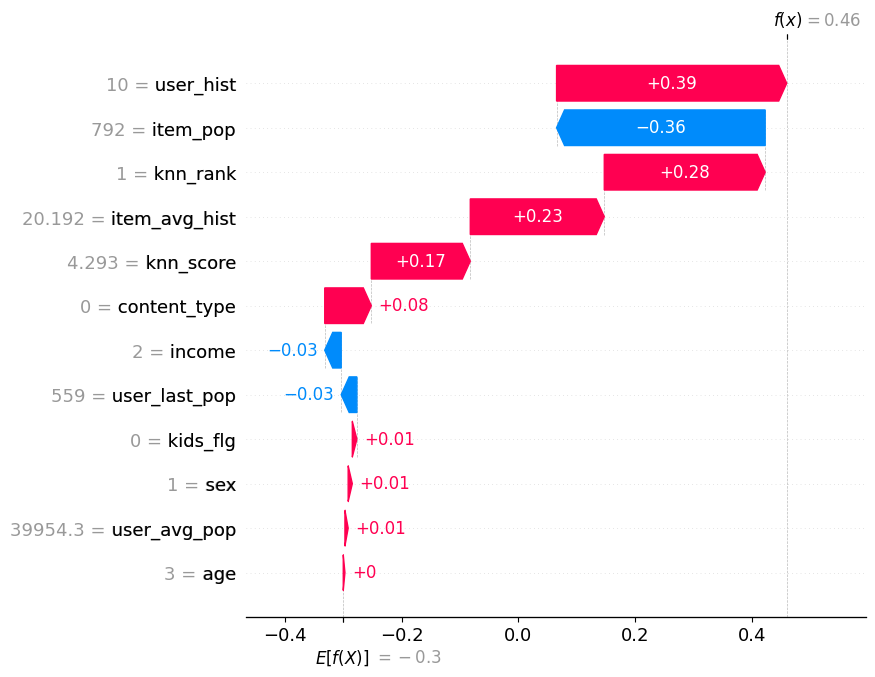

In [135]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

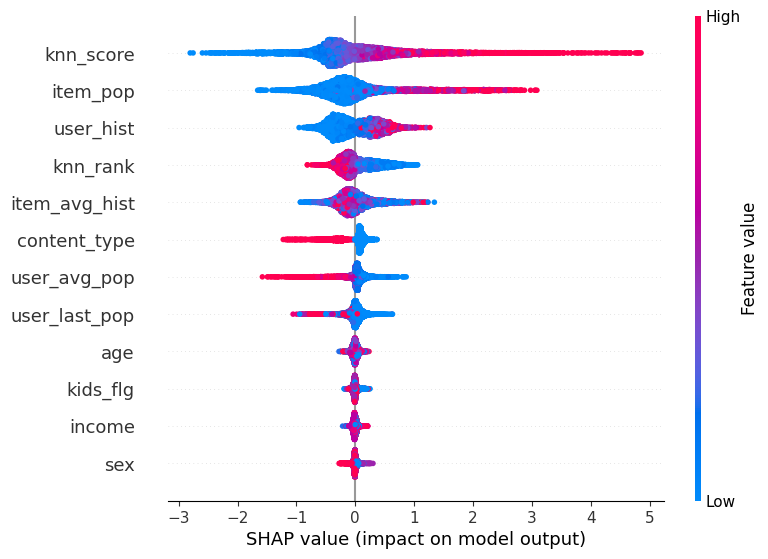

In [136]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

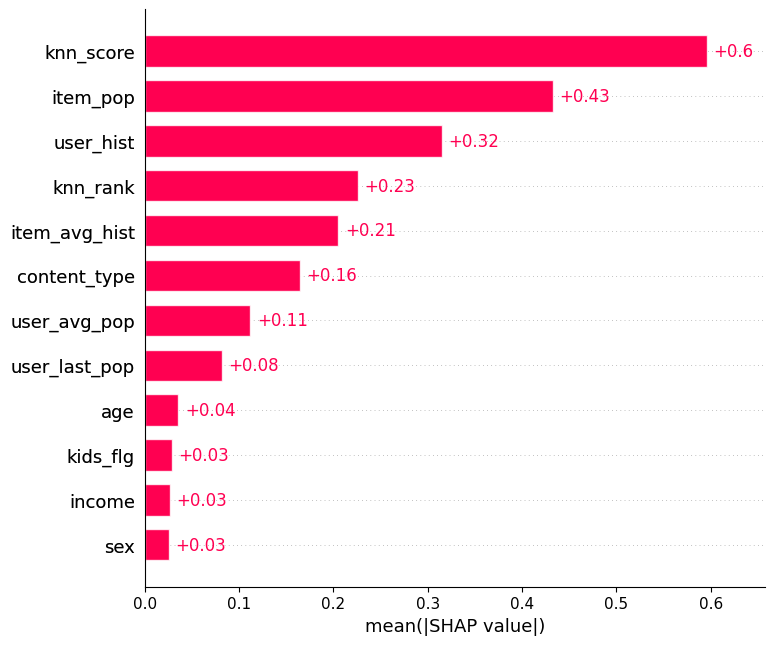

In [137]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [138]:
# Добавление скора и ранга от модели второго уровня
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    df[f'{name}_score'] = y_pred_scores
    df.sort_values(
        by=['user_id', f'{name}_score'],
        ascending=[True, False],
        inplace=True,
    )
    df[f'{name}_rank'] = df.groupby('user_id').cumcount() + 1

    return df

In [139]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'listwise')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,knn_score,knn_rank,age,income,sex,...,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target_ranker,listwise_score,listwise_rank
7,53,10517,2021-07-01,0.0,0.0,4.293477,1,3,2,1,...,0,1990.0,-1,18.0,-1,792.0,20.191919,0,0.460150,1
2,53,1650,2021-07-01,0.0,0.0,3.314463,4,3,2,1,...,0,2021.0,-1,12.0,-1,1689.0,19.117821,0,0.145937,2
1,53,1562,2021-07-01,0.0,0.0,4.063393,2,3,2,1,...,0,1995.0,-1,18.0,-1,848.0,22.623821,0,0.098697,3


### Count metrics

In [140]:
models_metrics['listwise'] = calc_metrics_(ranker_test, 'listwise_rank')
pd.DataFrame(models_metrics)

,knn,listwise
Precision@10,0.086417,0.086417
recall@10,0.196905,0.196905
ndcg@10,0.110502,0.113769
map@10,0.144956,0.152559
novelty@10,7.230680,7.230680


#### We got improvement in map and ndsg just as we planned

### Offline predictions

In [168]:
ranker_all_data = pd.concat([ranker_train, ranker_val, ranker_test])
y_pred: np.ndarray = listwise_model.predict(ranker_all_data[cols])
ranker_all_data = add_score_and_rank(ranker_all_data, y_pred, "listwise")

In [170]:
ranker_all_data = (
    ranker_all_data[['user_id', 'item_id', "listwise_rank"]]
    .sort_values(['user_id', "listwise_rank"])
    .groupby('user_id')
    .head(10)
)


In [172]:
ranker_all_data.drop("listwise_rank", axis=1, inplace=True)

In [163]:
ranker_preds = (ranker_all_data.groupby(['user_id'])
        .agg({'item_id': lambda x: x.tolist()})
        .reset_index()
        .set_index('user_id')
        .to_dict()['item_id']
)

In [177]:
ranker_preds[3]

[13849, 6208, 2220, 3475, 15719, 8252, 8447, 9550, 10464, 14703]

In [179]:
with open("../service/recmodels/ranker_recs.pkl", "wb") as file:
    pickle.dump(ranker_preds, file)